In [7]:
from numpy import sin, cos, linalg, array, pi, arange
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

In [8]:
class Pendulum:

    def __init__(self, Δx, θ_0, ω_0, r):
        self.ℓ = 0.1
        self.g = 9.8
        self.θ = [θ_0]
        self.ω = [ω_0]
        self.r = r
        self.Δx = Δx
        
        self.ρ = 1 ### density
        self.m = 4/3*pi*self.r**3*self.ρ ### mass = volume*density

    # Returns the gradient of theta (omega)
    def θGrad(self, θ, ω):
        return ω

    # Returns the gradient of omega (omega')
    def ωGrad(self, θ, ω):
        return -1*self.g/self.ℓ*sin(θ)
        
    # Update theta and omega for timestep delta, according to the Euler method.

    def IntegrateStep(self, delta):
        """
        Append new theta and omega states to the internal lists, which result from
        the time step delta. Integration done via the Runge–Kutta Method.
        """
        j, k = {}, {}
      
        j[0] = k[0] = 0

        for i in [1, 2, 3, 4]:
            h = delta/2 if i == 2 or i == 3 else delta

            for (var, func) in [(j, self.θGrad),(k, self.ωGrad)]:
                
                var[i] = func(self.θ[-1] + h*var[i-1], self.ω[-1] + h*var[i-1])
        
        for (var, state) in [(j, self.θ), (k, self.ω)]:
            
            state.append(state[-1] + h/6*(var[1] + 2*var[2] + 2*var[3] + var[4]))
    
        return
    
    
    def Transform(self, θ):
        return (self.ℓ*sin(θ)+self.Δx, -self.ℓ*cos(θ))
    
    def MakeArtists(self):
        (x, y) = self.Transform(self.θ[-1])
        
        mass = plt.Circle((x, y), radius=self.r , color='k')
        
        string, = plt.plot([self.Δx, x], [0, y], '-', color='k')
        
        return [mass, string]
    
class Cradle:
    
    def __init__(self, pendParams):
        self.pendulums = self.InitialisePends(pendParams)

        
    def InitialisePends(self, pendParams):
        pendulums = []
        
        ## ϵ is the spacing between masses at rest
        ϵ = 0.0001
        width = 0
        for (θ_0, ω_0, r) in pendParams:
            width += r + ϵ
            
        ## symmetrically place pendulums around x = 0
        Δx = -width/2
        
        assert(len(pendParams)>0)
        (θ_0, ω_0, r) = pendParams[0]
        pendulums.append(Pendulum(Δx, θ_0, ω_0, r))
        for i in range(1, len(pendParams)):
            (θ_0_prev, ω_0_prev, r_prev) = pendParams[i-1]
            (θ_0, ω_0, r) = pendParams[i]
            Δx += r_prev + r + ϵ
            pendulums.append(Pendulum(Δx, θ_0, ω_0, r))
            
        return pendulums
    
    def HasCollided(self, pen1, pen2):
        pen1_loc = array(pen1.Transform(pen1.θ[-1]))
        pen2_loc = array(pen2.Transform(pen2.θ[-1]))
        if linalg.norm(pen1_loc - pen2_loc) <= pen1.r + pen2.r:
            if linalg.norm(pen1_loc - pen2_loc) <= 0.98*(pen1.r+pen2.r):
                raise ValueError("Collision detected late, consider using a smaller time step!")
            return True
    
    def ElectrostaticRepulsion(self):
        for (pen1, pen2) in itertools.combinations(self.pendulums, 2):
            if self.HasCollided(pen1, pen2):
                temp_ω = pen1.ω[-1]
                pen1.ω[-1] = (pen1.m-pen2.m)/(pen1.m+pen2.m)*temp_ω + (2*pen2.m/(pen1.m+pen2.m))*pen2.ω[-1]
                pen2.ω[-1] = (2*pen1.m/(pen1.m+pen2.m))*temp_ω + (pen2.m-pen1.m)/(pen1.m+pen2.m)*pen2.ω[-1]
    

In [1]:
from matplotlib import rcParams, rc
from IPython.display import HTML
##Warning this code requires a working ffmpeg installation


def render_draft():
    rcParams['figure.dpi'] = 80
    rcParams['figure.figsize'] = (8,6)

def render_final():
    rcParams['figure.dpi'] = 250
    rcParams['figure.figsize'] = (8,6)

In [10]:
from matplotlib import animation

def plot_physics(timeinterval, t_step, pendParams, filename):
    t_domain = arange(0, timeinterval, t_step)
    last_frame = 0
    frame_length = 1/60
    
    cradle = Cradle(pendParams)
    
    fig = plt.figure()
    plt.axis('off')
    ax = plt.gca()
    ax.set_aspect(aspect=1)

    plt.ylim((-0.12, 0))
    plt.xlim((-.13, 0.13))

    ## initialise environment
    
    object_instances = []
    
    last_collision = 0
    
    for t in t_domain:
        if t - last_collision > t_step:
            cradle.ElectrostaticRepulsion()
            last_collision = t
        
        for pend in cradle.pendulums:
            pend.IntegrateStep(t_step)
        
        if t - last_frame >= frame_length:
            objects = []
            for pend in cradle.pendulums:
                (mass, string) = pend.MakeArtists()
                objects.append(string)
                objects.append(ax.add_patch(mass))
            object_instances.append(objects)
            last_frame = t
    
    ani = animation.ArtistAnimation(fig, object_instances, interval=frame_length*1000*2)

    ani.save(filename + '.mp4')
    plt.close()


KeyboardInterrupt: 

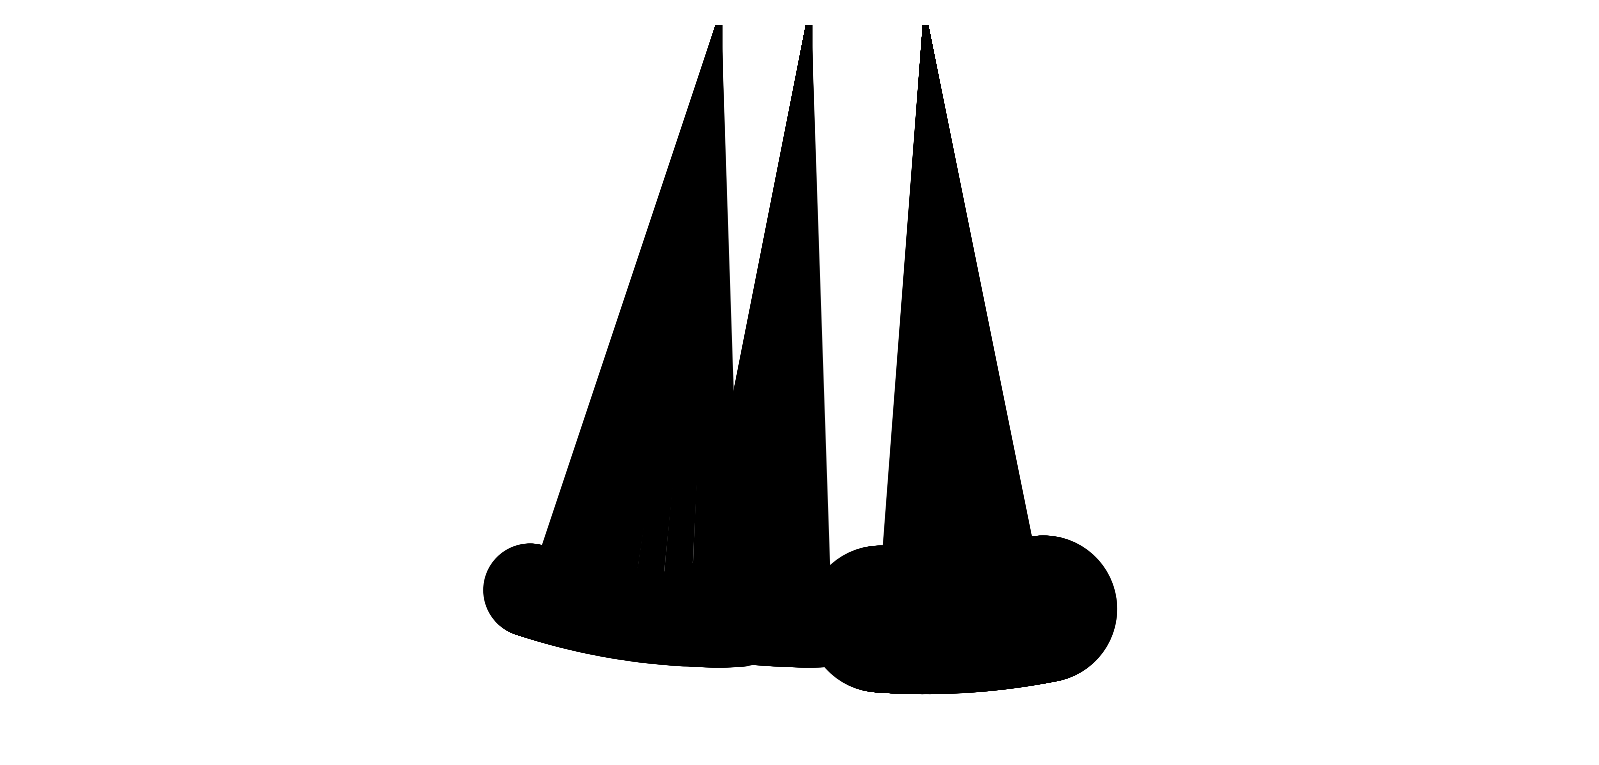

In [11]:
render_final()

pendParams = [(0, 0, 0.0075),
              (0, 0, 0.0075),
              (.2, 0, 0.0120)]

t_step = 0.000002
while True:
    try:
        plot_physics(10, t_step, pendParams, f'2_small_1_big')
    except ValueError:
        t_step *= 0.5
        continue
    break

In [ ]:
render_final()

pendParams = [(0, 0, 0.0075),
              (0, 0, 0.0075),
              (0, 0, 0.0075),
              (0, 0, 0.0075),
              (.2, 0, 0.0120)]

t_step = 0.000001
while True:
    try:
        plot_physics(10, t_step, pendParams, f'4_small_1_big')
    except ValueError:
        t_step *= 0.5
        continue
    break

In [15]:
render_final()

pendParams = [(0, 0, 0.0075),
              (0, 0, 0.0075),
              (0, 0, 0.0075),
              (0, 0, 0.0075),
              (.5, 0, 0.0120)]

t_step = 0.00001
while True:
    try:
        plot_physics(20, t_step, pendParams, f'4_small_1_big_large_swing')
    except ValueError:
        t_step *= 0.5
        continue
    break